*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Réseau de neurones convolutifs </div>

*******

<div style="padding:20px;color:black;margin:0;font-size:150%;display:fill;border-radius:8px;background-color:#d9d9d9;overflow:hidden;font-weight:100"><strong>Présentation</strong></div>
<a class="anchor" id="Section_1.1"></a>

### Etude de faisabilité d'un moteur de classification, basé sur une description et sur une image

Cette étude vise à comparer deux approches, le notebook 1 classe les images selon leur description et le notebook 2 classe les images en utilisant une méthode de transfert Learning basée sur VGG16.      

### Extraction des features des images : algorithme de type **SIFT**        
- Créations des descripteurs de chaque image         
- Pour chaque image passage en gris et equalisation      
- création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image       
- création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs        
### Un algorithme de type CNN Transfer Learning : **VGG16** (google)
- Création des dossiers
- chargement des poids
- Création des nouveaux blocs

Une réduction en 2 dimensions **T-SNE**, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle.      
Réalisation d’une mesure pour confirmer l'analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters, basée sur **l'ARI**.        
Démonstration, par cette approche, de la faisabilité de regrouper automatiquement des produits de même catégorie.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir
import shutil


import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

##  1) SIFT, PCA & Clustering

In [30]:
path = "C:/Users/fbbou/PycharmProjects/P6_new/Images"

In [3]:
# Création des adresses des dossiers des classes

path_c1 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Home Furnishing"
path_c2 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Baby Care"
path_c3 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Watches"
path_c4 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Home Decor & Festive Needs"
path_c5 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Kitchen & Dining"
path_c6 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Beauty and Personal Care"
path_c7 = "C:/Users/fbbou/PycharmProjects/P6_new/pictures/Computers"

list_path = [path_c1, path_c2, path_c3, path_c4, path_c5, path_c6, path_c7]

In [4]:
# Création d'une liste des noms des photos
list_photo = [file for file in listdir("C:/Users/fbbou/PycharmProjects/P6_new/Images")]
print(len(list_photo))

1050


In [5]:
# Création d'un df contenant les noms des photos et leurs labels
df_categ = pd.read_csv("df_categ.csv",sep=";")

for i in range(len(list_photo)):
    list_photo[i] = list_photo[i].replace('.jpg',"")

df = df_categ[df_categ['uniq_id'].isin(list_photo)]

df["path"] = df["uniq_id"]+'.jpg'

In [6]:
# Création d'un liste contenant les différentes catégories
df["categorie"] = df["categorie"].str.strip()
list_labels = list(df["categorie"].unique())
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [7]:
df.shape

(1050, 3)

In [131]:
# Les photos sont rangées par classes
i=0
for l in list_labels:
    lp = list_path[i]
    i += 1
    for x in (df[df["categorie"]==l]["path"]):
        shutil.move(path +'/'+ x , lp + '/' + x)

### Création d'un set de train et un autre de test

In [60]:
import splitfolders
splitfolders.ratio("pictures", output="pict", seed=42, ratio=(0.8,0.2))

Copying files: 1050 files [00:08, 118.98 files/s]


### Label encoder

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["categorie"])

In [9]:
df.groupby("label").count()

,uniq_id,categorie,path
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


Home Furnishing


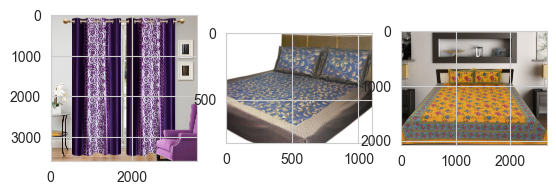

Baby Care


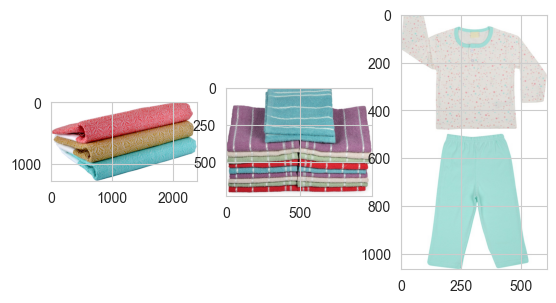

Watches


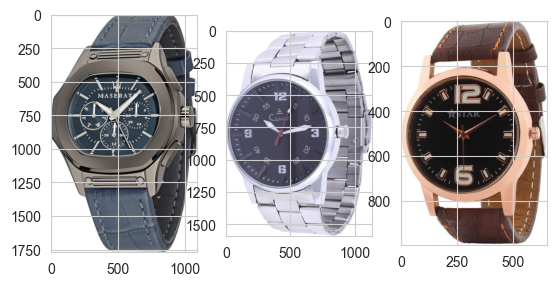

Home Decor & Festive Needs


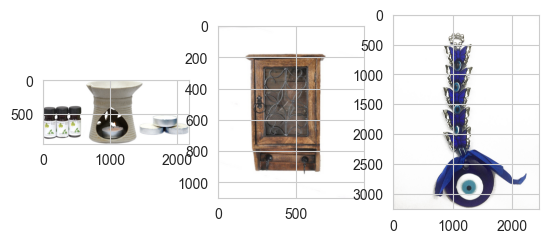

Kitchen & Dining


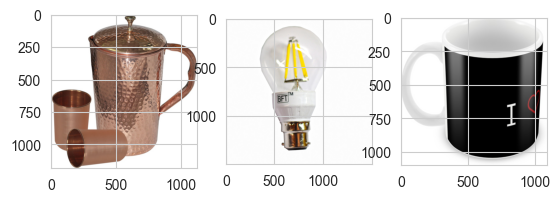

Beauty and Personal Care


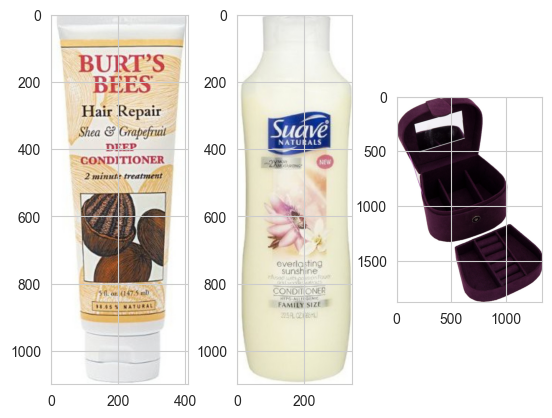

Computers


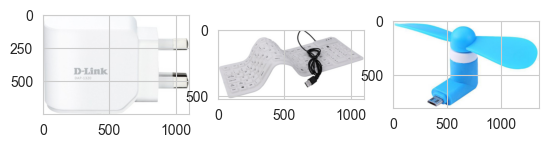

In [10]:
# Affichage de trois images par classes
from matplotlib.image import imread

path_print = "C:/Users/fbbou/PycharmProjects/P6_CNN/Flipkart/Images"
def list_fct(name) :
    list_image_name = [df["path"][i] for i in range(len(df)) if df["categorie"][i]==name]
    return list_image_name

for name in list_labels :
    print(name)
    for i in range(3):
        plt.subplot(131  + i)
        filename = path_print + '/' + list_fct(name)[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

### Exemple de descripteur de l'algorythme SIFT

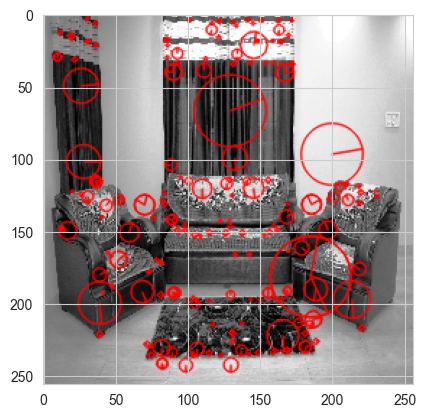

Descripteurs :  (200, 128)

[[120.  77.   3. ...   3.   1.  33.]
 [  5.   1.   0. ...   5.   1.  11.]
 [  0.   0.   0. ...   2.   2.   2.]
 ...
 [  0.   0.   0. ...   1.   6.  30.]
 [  1.  26.  49. ...   1.   0.   0.]
 [  3.   2.   6. ...   1.  37.  40.]]


In [11]:
import cv2

sift = cv2.SIFT_create(200)
image = cv2.imread(path_print + '/'+df["path"][999],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
image = cv2.resize(image,(256,256))
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,None, color=(255,0,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [12]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(nfeatures = 500)
i=0
for image_num in range(len(list_photo)) :
    if image_num % 100 == 0 : print(image_num)
    image = cv2.imread(path_print +'/'+ list(df["path"])[image_num],0)
    image = cv2.resize(image,(256,256))
    # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)

    a= np.array(des)
    a.resize((500,128))
    sift_keypoints.append(a)

0
100
200
300
400
500
600
700
800
900
1000


In [14]:
print(len(sift_keypoints),len(sift_keypoints[0]))

1050 500


In [15]:
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

In [16]:
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

Nombre de descripteurs :  (525000, 128)


In [17]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  725
Création de 725 clusters de descripteurs ...
temps de traitement kmeans :            13.05 secondes


In [18]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.12 secondes


In [19]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 725)
Dimensions dataset après réduction PCA :  (1050, 90)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [20]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["categorie"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

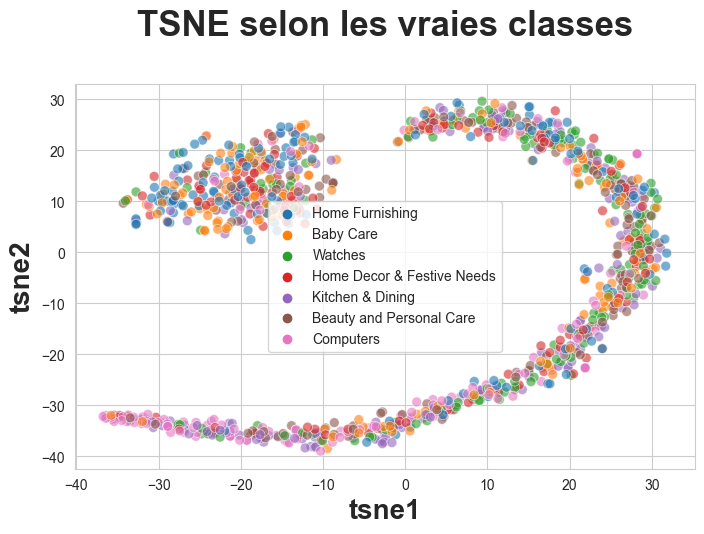

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 10})

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [22]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

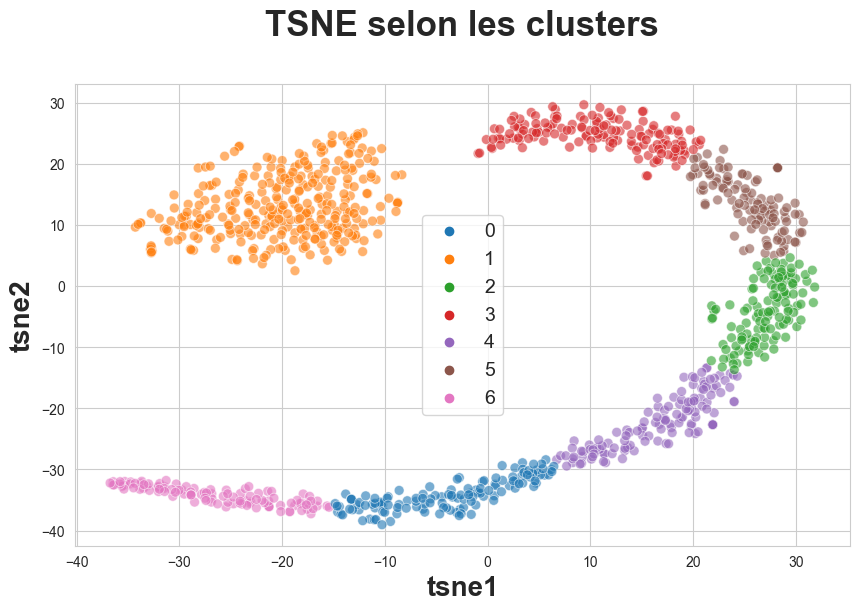

ARI :  0.04713332458791373


In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = df["categorie"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Construction d'un CNN à patir de VGG16

In [24]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1,0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.1,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [25]:
train_data_dir ="C:/Users/fbbou/PycharmProjects/P6_new/pict/train"
test_data_dir ="C:/Users/fbbou/PycharmProjects/P6_new/pict/test"

train_gen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

valid_gen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_gen = train_generator.flow_from_directory(test_data_dir,
                                               target_size=(224,224),
                                               class_mode=None,
                                               batch_size=1,
                                               shuffle=False,
                                               seed=42)

Found 756 images belonging to 7 classes.
Found 84 images belonging to 7 classes.
Found 210 images belonging to 7 classes.


In [26]:
def create_model(input_shape, n_classes, optimizer='rmsprop',fine_tune=0):

    conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune] :
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs = output_layer)

    model.compile(optimizer=optimizer,
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [27]:
from keras.optimizers import Adam

input_shape = (224,224,3)
optim_1 = Adam(learning_rate=0.001)
n_classes = 7

n_steps = train_gen.samples // BATCH_SIZE
n_val_steps = valid_gen.samples // BATCH_SIZE
n_epochs = 35

vgg_model = create_model(input_shape, n_classes, optim_1,fine_tune=0)

In [28]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

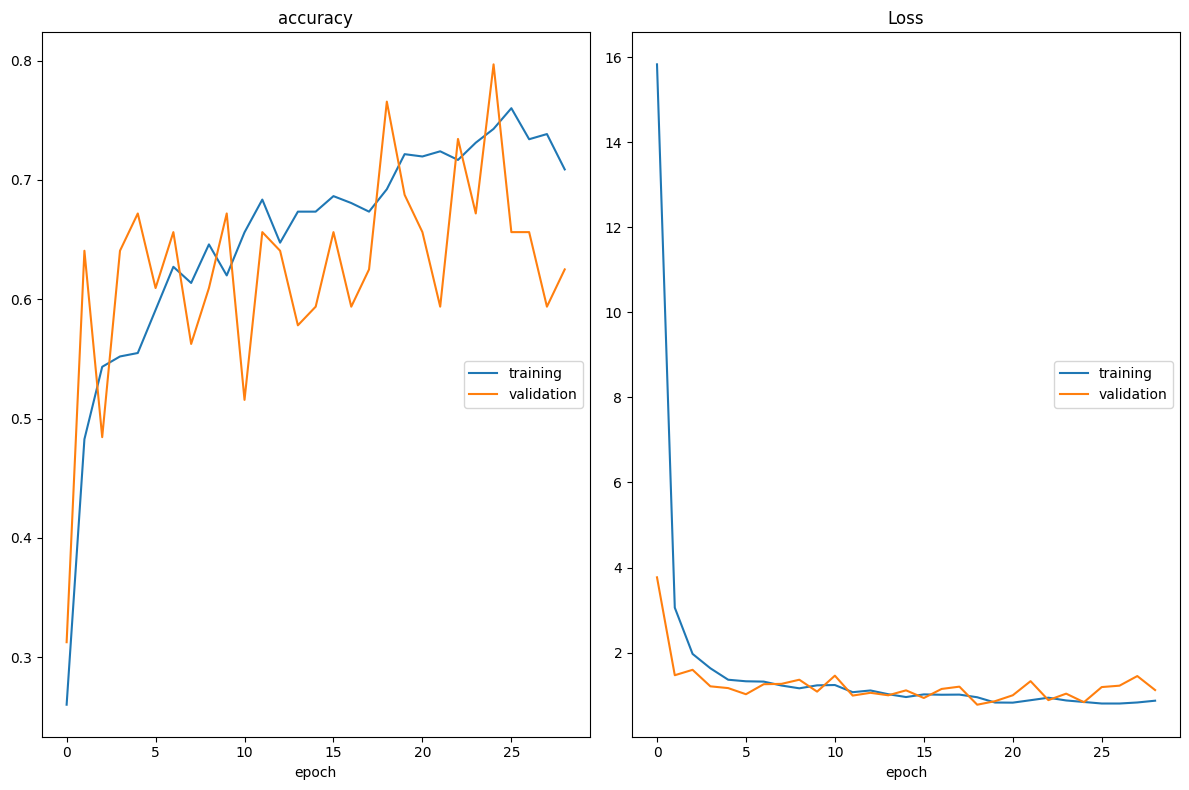

accuracy
	training         	 (min:    0.260, max:    0.760, cur:    0.709)
	validation       	 (min:    0.312, max:    0.797, cur:    0.625)
Loss
	training         	 (min:    0.801, max:   15.832, cur:    0.868)
	validation       	 (min:    0.774, max:    3.769, cur:    1.118)
11/11 [==============================] - 105s 9s/step - loss: 0.8677 - accuracy: 0.7088 - val_loss: 1.1183 - val_accuracy: 0.6250
CPU times: total: 4h 44min 45s
Wall time: 44min 23s


In [89]:
%%time

vgg_history = vgg_model.fit(train_gen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=valid_gen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [90]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = test_gen.classes
class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(test_gen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

210/210 [==============================] - 28s 132ms/step


In [91]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 70.95%


## Fine-tuning

In [93]:
# Reset our image data generators
train_gen.reset()
valid_gen.reset()
test_gen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

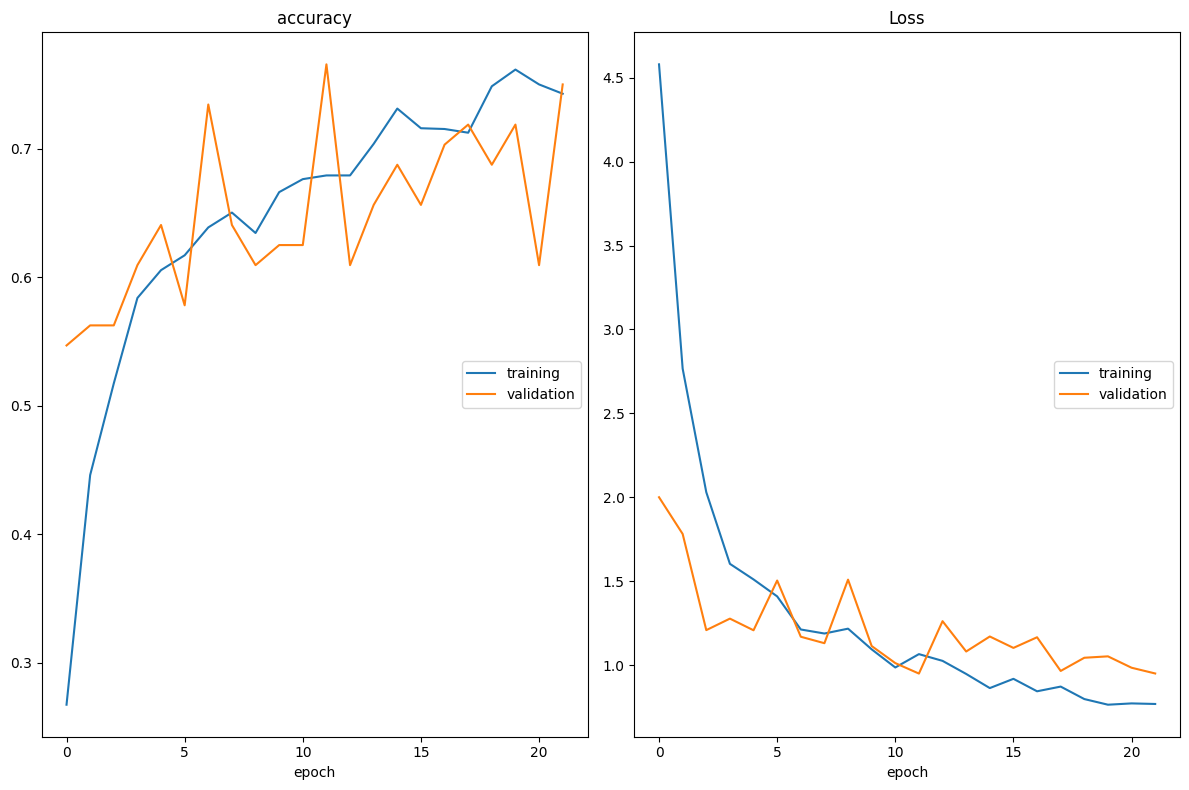

accuracy
	training         	 (min:    0.267, max:    0.762, cur:    0.743)
	validation       	 (min:    0.547, max:    0.766, cur:    0.750)
Loss
	training         	 (min:    0.765, max:    4.579, cur:    0.769)
	validation       	 (min:    0.950, max:    2.001, cur:    0.951)
11/11 [==============================] - 107s 10s/step - loss: 0.7693 - accuracy: 0.7428 - val_loss: 0.9510 - val_accuracy: 0.7500
CPU times: total: 3h 45min 58s
Wall time: 36min 6s


In [95]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(train_gen,
                                  batch_size=BATCH_SIZE,
                                  epochs=35,
                                  validation_data=valid_gen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [99]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(test_gen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

210/210 [==============================] - 27s 130ms/step


In [100]:
from sklearn.metrics import accuracy_score

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 66.67%
